In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import pandas as pd
import numpy as np
import re
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

## read data and clean column names

In [3]:
#Spotfire link: 
#https://spotfiremrlprd.merck.com/spotfire/wp/analysis?file=/BOB%20Project%20Support/ELN%20BioAssay/PSCS/Self%20Service%20-%20DPS%20Protein%20Formulation%20Characterization/DPS%20Protein%20Formulation%20Characterization
#os.chdir('c:\\Users\\chenya68\\OneDrive - Merck Sharp & Dohme LLC\\Documents\\gp-data')
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-alldata.csv')
print(len(df))
df.head()

2743


,Import Date,ISID,Project,Protein,Modality,Control Type,Stress Condition,Temp. (°C),Time (Days),Well ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified Excipients,1st Excipient in Sample,2nd Excipient in Sample,#Conc for Excipient1,Origin of data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [4]:
# remove special character #,%,(,),.,/
df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df.columns]
df.columns = df.columns.str.replace('Δ', 'chg')

# replace Stir/Stirring with Agitation in the Stress_Condition
df['Stress_Condition'] = df['Stress_Condition'].replace(['Stir','Stirring'],"Agitation")

# Drop out stress studies with limited data 
df.drop(df[df['Stress_Condition'].isin(['Freeze Thaw', 'AAPH', 'tBHP', 'tBPH'])].index, inplace=True)

# Drop out bad data entry
df.drop(df[df['Project'].isnull() & df['Protein'].isnull()].index, inplace=True)

# Some scientist put all information in the sample name,mostly for Trop2 program, more like a robustness study. Drop out for now
df.drop(df[df['Stress_Condition'].isnull() & df['Temp_C_'].isnull()].index, inplace=True)

print(len(df))
#df.to_csv('dps-cleaned-colnames.csv',index = None)

2407


In [5]:
#cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_','Protein_Conc_mg_mL_']
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_']
#cols_target = ['UP_SEC_Monomer','UP_SEC_LMW','UP_SEC_HMW']
cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']

cols_other_target = ['UP_SEC_chg_Monomer','UP_SEC_chg_LMW','UP_SEC_chg_HMW',
                     'UP_SEC_Abs_chg_Monomer_','UP_SEC_Abs_chg_LMW_',
                     'UP_SEC_Abs_chg_HMW_','UP_SEC_Monomerlabels',
                     'CE_SDS_Red_Purity_Sum','CE_SDS_Red_Purity_Sum',
                     'CE_SDS_Red_chg_Purity','CE_SDS_NR_Purity_Sum',
                     'CE_SDS_NR_chg_Purity','RP_UPLC_Main', 'RP_UPLC_Post_Peak',
                     'RP_UPLC_Pre_Peak','RP_UPLC_chg_Main',
                     'RP_UPLC_chg_Post_Peak', 'RP_UPLC_chg_Pre_Peak']
cols_other = ['_Conc_for_Excipient1','1st_Excipient_in_Sample','2nd_Excipient_in_Sample',
              'BATCH_BIOREG_ID','C_BIOREG_ID','Control_Type','IMPORTED_DATA_FILE_NAME','ISID',
              'Import_Date','Notebook_','Origin_of_data','Project',	'Well_ID']
cols_feature0 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH',
                 'Additional_Excipient_Name']
cols_feature_numeric= ['NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']

In [6]:
# Focus on thermal stress or no stress situation
# Understand the missing values across columns
"""
    Stress studies other than thermal stress are tested for leading formulation, identified by thermal stress. 
    That said, the thermal stress would be the target situation where we could like to optimize the formulation
    We'll focus on thermal stress from now on.
"""
df_other_stress = df[(df['Stress_Condition'] != 'Thermal Stress') & (~df['Stress_Condition'].isnull())]
result = df_other_stress.groupby(['Project','Protein', 'Modality','Stress_Condition'])[cols_feature0].nunique()
result

Buffer  NaCl_mM_  \
Project    Protein        Modality Stress_Condition                         
Surfactant DCC000141_005  ADC      Agitation                  1         1   
           DCC000141_007  ADC      Light stress 0.2 x         1         1   
           DCC000706_005  ADC      Agitation                  1         1   
           MK-1248        mAb      Agitation                  1         1   
                                   G-Force                    1         1   
           MK-4166        mAb      Agitation                  1         1   
           MK-7110        mAb      Agitation                  1         1   
           Trab           ADC      Light stress 0.2 x         1         1   
Tie2       DAB016505_008  mAb      Agitation                  2         2   
                                   Control                    2         2   
                                   High pH                    2         2   
                                   Light Stress 0.2x          2         2   
                                   Light Stress 0.2x CT       2         2   
                                   Low pH                     2         2   
                                   Oxidation                  2         2   
Trop2      DAB0156292_013 Fab      Light stress 0.2 x         1         1   
           DCC000159_003  ADC      Light stress 0.2 x         0         1   
           DCC000238_004  ADC      Light stress 0.2 x         0         1   
           DCC000250_003  ADC      Light stress 0.2 x         0         1   
           DCC000712_002  ADC      Light stress 0.2 x         1         1   
           DCC000770_032  ADC      Agitation                  1         1   

                                                         PS80_  Sucrose_  \
Project    Protein        Modality Stress_Condition                        
Surfactant DCC000141_005  ADC      Agitation                 1         1   
           DCC000141_007  ADC      Light stress 0.2 x        1         1   
           DCC000706_005  ADC      Agitation                 1         1   
           MK-1248        mAb      Agitation                 3         1   
                                   G-Force                   1         1   
           MK-4166        mAb      Agitation                 1         1   
           MK-7110        mAb      Agitation                 1         1   
           Trab           ADC      Light stress 0.2 x        1         1   
Tie2       DAB016505_008  mAb      Agitation                 2         1   
                                   Control                   2         1   
                                   High pH                   2         1   
                                   Light Stress 0.2x         2         1   
                                   Light Stress 0.2x CT      2         1   
                                   Low pH                    2         1   
                                   Oxidation                 2         1   
Trop2      DAB0156292_013 Fab      Light stress 0.2 x        2         2   
           DCC000159_003  ADC      Light stress 0.2 x        1         1   
           DCC000238_004  ADC      Light stress 0.2 x        1         1   
           DCC000250_003  ADC      Light stress 0.2 x        1         1   
           DCC000712_002  ADC      Light stress 0.2 x        1         1   
           DCC000770_032  ADC      Agitation                 1         1   

                                                         Trehalose_  pH  \
Project    Protein        Modality Stress_Condition                       
Surfactant DCC000141_005  ADC      Agitation                      1   2   
           DCC000141_007  ADC      Light stress 0.2 x             1   1   
           DCC000706_005  ADC      Agitation                      1   1   
           MK-1248        mAb      Agitation                      1   1   
                                   G-Force                        1   1   
           

In [7]:
# Focus on thermal stress or no stress
df = df[(df['Stress_Condition'].isnull()) | (df['Stress_Condition'] == 'Thermal Stress')]
print(df['Buffer'].unique())

['Acetate' 'Citrate' 'Histidine' 'Water' 'Phosphate' 'Keytruda' 'Frozen'
 'Bulk Dialysis' 'Glutamate' 'Succinate' '10 mM Histidine']


In [8]:
# Clean the values in 'Buffer' column, remove ambiguous formulation
df['Buffer'] = df['Buffer'].replace('10 mM Histidine',"Histidine")
df.drop(df[df['Buffer'].isin(['Bulk Dialysis', 'Frozen', 'Water','Keytruda' ])].index, inplace=True)

# Fill nan value in Protei concentration with 1mg/ml at which DPS typically run assay 
# DANGER: Double check with DPS/ELN
df['Protein_Conc_mg_mL_'].fillna(1, inplace=True)
print(len(df))

1865


## Distribution of features across all groups

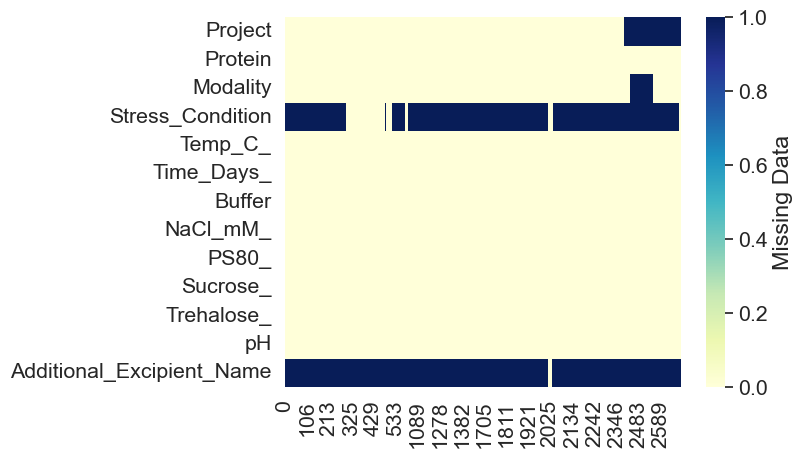

In [9]:
# missing data visualization across identifiers and formulation factors
sns.set(font_scale=1.4)
sns.heatmap(df[cols_group + cols_feature0].isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

NaCl_mM_ [  0  50 150  75]
PS80_ [0.   0.02]
Sucrose_ [0.  7.  9.  7.5 5. ]
Trehalose_ [0 7 9]
pH [5.   6.2  6.8  5.6  5.5  6.5  6.   4.5  5.2  7.4  4.3  4.7  4.85 3.9
 4.4  4.9  5.4  5.63 4.6  5.1  4.2  5.9  6.1  6.7  4.   7.  ]


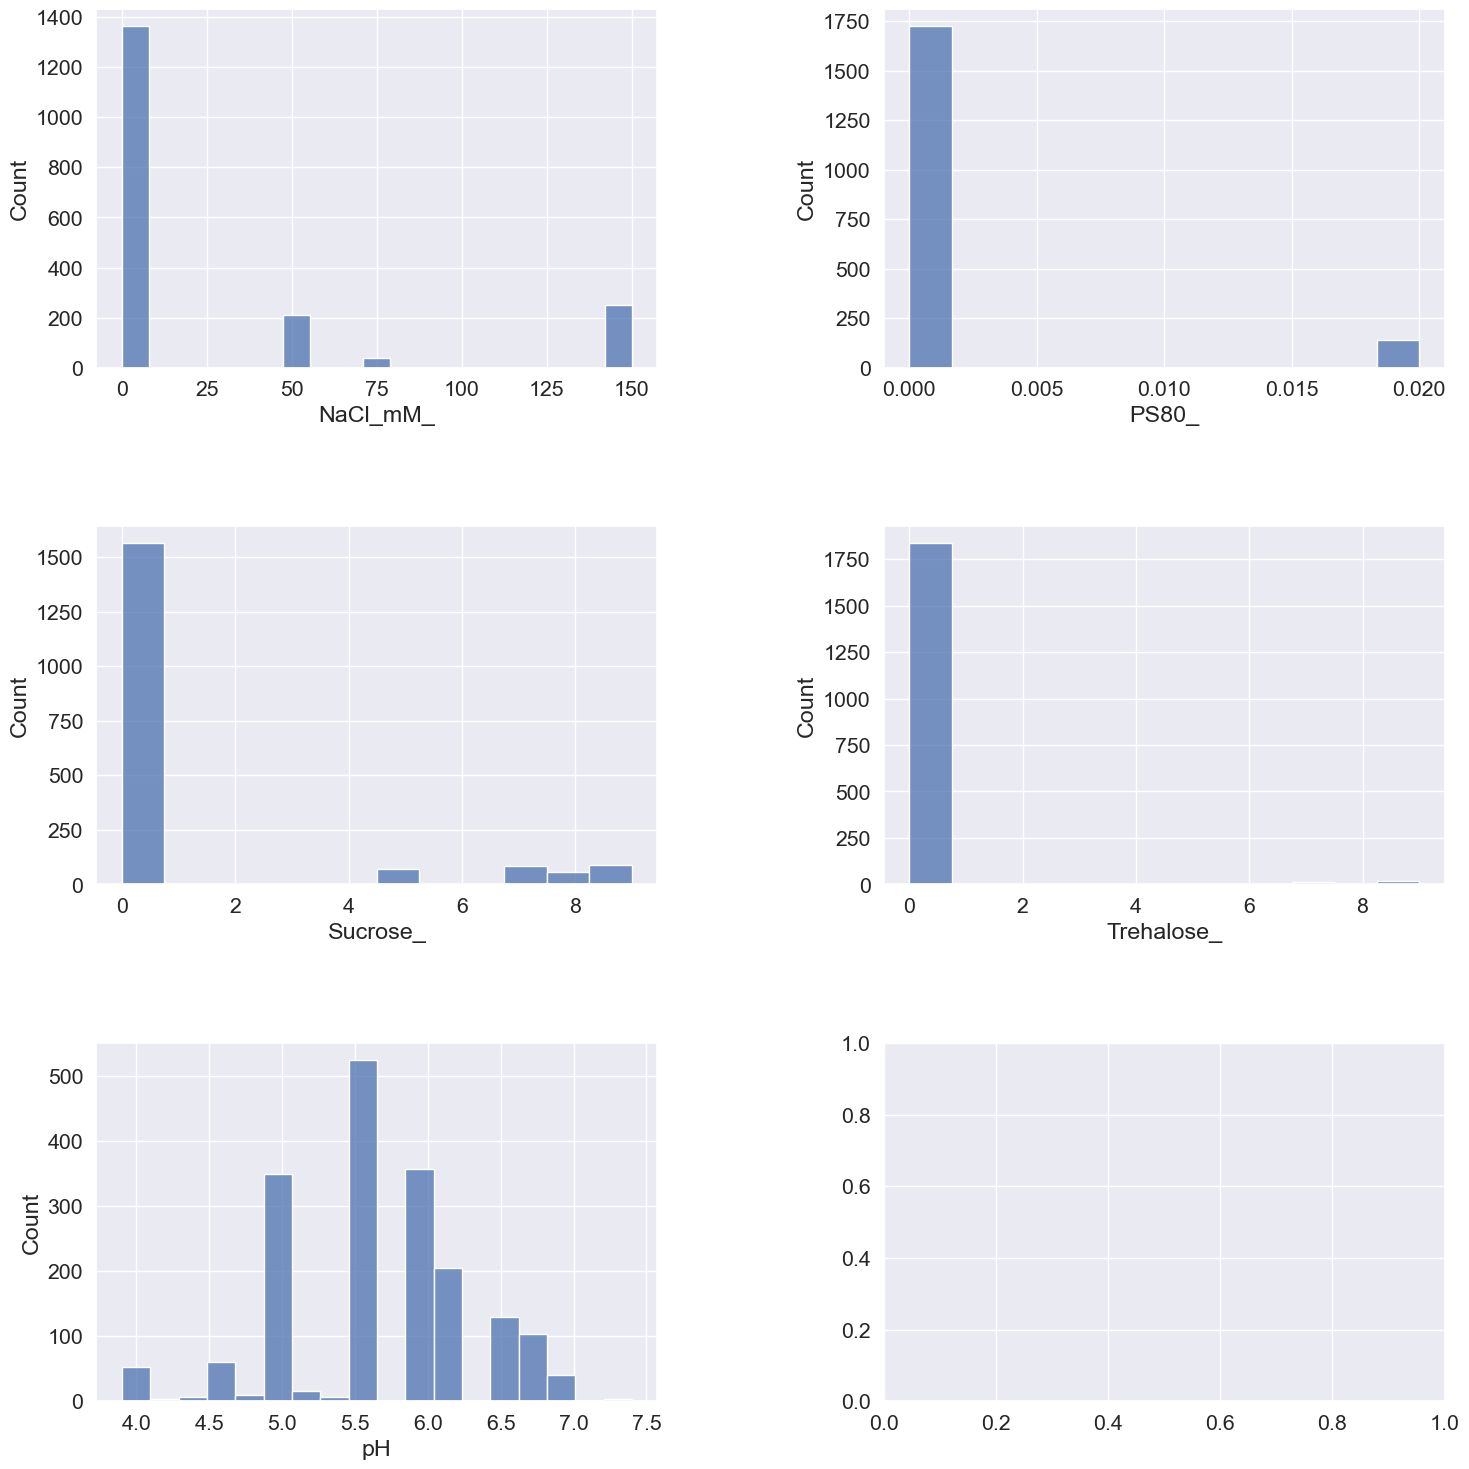

In [11]:
#Distributions of numeric features across all groups
fig, axes = plt.subplots(3,2, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(cols_feature_numeric):
    print(col,df[col].unique())
    sns.histplot(df[col], ax=ax[i]) # histogram call
    #ax[i].set_title(col)
    # remove scientific notation for both axes
    ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
#figName = 'featureDist.jpg'
#plt.savefig(os.path.join(figPath,figName))
plt.show()

Buffer ['Acetate' 'Citrate' 'Histidine' 'Phosphate' 'Glutamate' 'Succinate']
0


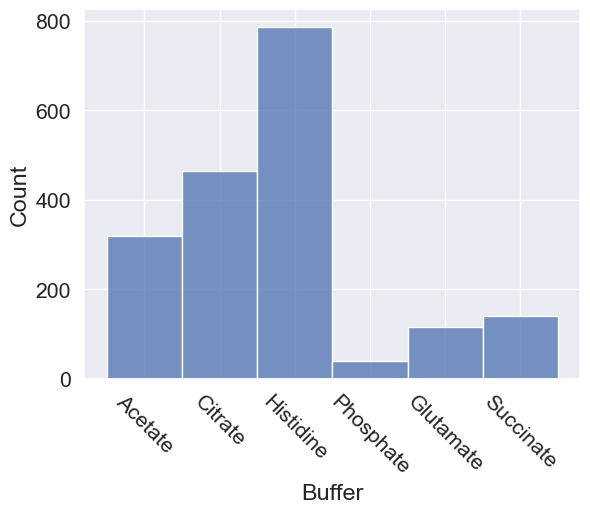

Additional_Excipient_Name [nan '  0.5%MoNi ' ' 1%SBebCD' '002%PO188' '002%PS20' '002%PS80'
 '005%MoNi' '05%MoNI' '1%HPbCD' '1%HPgCD' '1%MoNi' '1%SBEbCD' '1%gCD']
1843


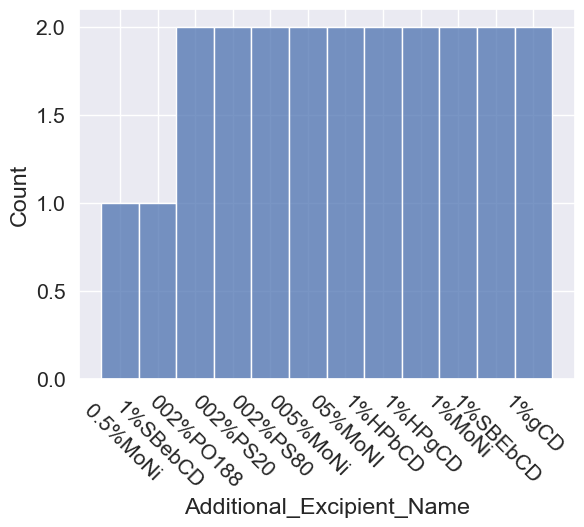

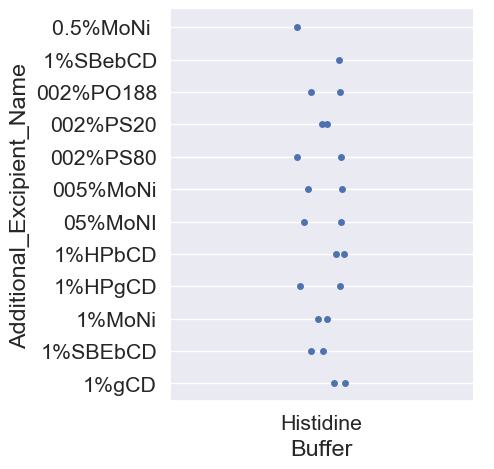

In [12]:
#Distributions of cate features
sns.set(font_scale=1.4)
for i, col in enumerate(['Buffer','Additional_Excipient_Name']):
    print(col,df[col].unique())
    print(df[col].isna().sum())
    #sns.catplot(data=df, x="Buffer", y="pH", jitter=False)
    sns.histplot(df[col]) 
    fig.tight_layout(w_pad=6, h_pad=4) # change padding
    plt.xticks(rotation=-45)
    plt.show()
    #ax[i].set_title(col)
sns.catplot(data=df[~df['Additional_Excipient_Name'].isna()], x="Buffer", y="Additional_Excipient_Name", jitter=True)

In [10]:
# Remove entry with Additional_Excipients

df.drop(df[~df['Additional_Excipient_Name'].isnull()].index, inplace=True)

cols_feature0 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH',
                 'Additional_Excipient_Name']
print(len(df))

1843


In [12]:
df.to_csv('data/dps-cleaned-missing.csv',index = None)

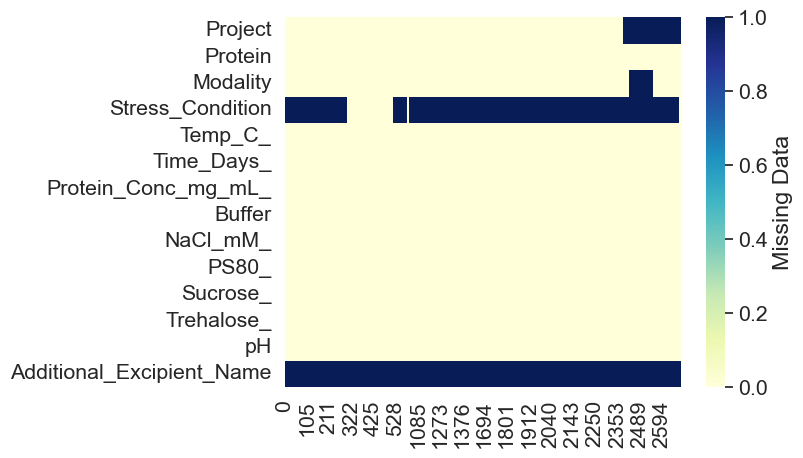

In [14]:
# missing data visualization across identifiers and formulation factors
sns.set(font_scale=1.4)
sns.heatmap(df[cols_group + cols_feature0].isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

In [268]:
print(df['Protein'].unique())
print(df['Protein'].unique().shape)
print(df['Modality'].unique())
print(df['Modality'].unique().shape)

['03BHZ' '69BHV' 'MK-2032' '68BHS' 'TDI' 'AB0411' 'AB0621' '65BKD' '98BLE'
 '99BLE' '64BLJ' 'DAB013887' 'DAB014071' 'DAB014072' 'DAB014074' 'DNB547'
 'DNB553' 'DNB557' 'DNB558' '21BMT' '48BMP' 'DAB015692_013'
 'DCC000492_005' 'DCC000674_005' 'DCC000706_005' 'Trab' 'SP10482'
 'SP009849' 'SP10478' 'SP10784' 'DAB014234' 'DAB014235' 'DAB014236'
 'DAB014238' 'DCC000770_007' 'DAB0156292_012' 'DAB0156292_013'
 'DCC000363_035' 'DCC000770_035' 'DCC000238_004' 'DCC000250_003'
 'DCC000712_002' 'DCC000159_003' 'DCC000770_032' 'DCC_1A' 'DCC_2B'
 'MK3475' 'Enhertu' 'ROR1' 'VLS-101' 'VLS-231']
(51,)
['mAb' 'BsAb' 'Fusion Protein' 'ADC' 'polymer conjugate' 'Trispecific'
 'Fab' nan]
(8,)


## split data into group by identifiers

In [14]:
# Update the sample identifier 
"""
    The protein concentration may deviate one from another in an acceptable range
    Thus, we remove the Protein concentration from sample identifier
"""
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_']

#get unique levels for identifiers and count for number of missing data

for col in cols_group:
    print(col,'identifier has',df[col].isna().sum(),'missing data points')
    print(df[col].unique())

Project identifier has 272 missing data points
['aTau' 'CD40' 'CEACAM5' 'FAP-TriNKET' 'IL-2Ra' 'Surfactant' 'Sutro IL-2'
 'TRACTr Nectin-4' 'Trop2' nan]
Protein identifier has 0 missing data points
['03BHZ' '69BHV' 'MK-2032' '68BHS' 'TDI' 'AB0411' 'AB0621' '65BKD' '98BLE'
 '99BLE' '64BLJ' 'DAB013887' 'DAB014071' 'DAB014072' 'DAB014074' 'DNB547'
 'DNB553' 'DNB557' 'DNB558' '21BMT' '48BMP' 'DAB015692_013'
 'DCC000492_005' 'DCC000674_005' 'DCC000706_005' 'Trab' 'SP10482'
 'SP009849' 'SP10478' 'SP10784' 'DAB014234' 'DAB014235' 'DAB014236'
 'DAB014238' 'DCC000770_007' 'DAB0156292_012' 'DAB0156292_013'
 'DCC000363_035' 'DCC000770_035' 'DCC000238_004' 'DCC000250_003'
 'DCC000712_002' 'DCC000159_003' 'DCC000770_032' 'DCC_1A' 'DCC_2B'
 'MK3475' 'Enhertu' 'ROR1' 'VLS-101' 'VLS-231']
Modality identifier has 108 missing data points
['mAb' 'BsAb' 'Fusion Protein' 'ADC' 'polymer conjugate' 'Trispecific'
 'Fab' nan]
Stress_Condition identifier has 1609 missing data points
[nan 'Thermal Stress']
Temp_

In [15]:
from sklearn.decomposition import PCA
from numpy.linalg import norm

def pca_similarity_factor(ts1: np.array, ts2: np.array, components = 3) -> float:
    n_samples1, n_features1 = np.shape(ts1)
    n_samples2, n_features2 = np.shape(ts2)
    components1 = min(n_samples1, n_features1)
    components2 = min(n_samples2, n_features2)
    new_components = min(components1,components2,components)
    pca1 = PCA(n_components = new_components)
    pca2 = PCA(n_components = new_components)
    pca1.fit(ts1)
    pca2.fit(ts2)
    len_ev = len(pca1.explained_variance_)
    data1 = zip(pca1.explained_variance_,pca1.components_)
    data2 = zip(pca2.explained_variance_,pca2.components_)
    numerator = sum([ev1*ev2*(np.cos(angle_between(v1,v2))**2) for ev1,v1 in data1 for ev2,v2 in data2])
    denominator = sum([pca1.explained_variance_[i]*pca2.explained_variance_[i] for i in range(len_ev)])
    similarity_factor = numerator/denominator
    return similarity_factor

def angle_between(v1,v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u,v2_u),-1.0,1.0))

def unit_vector(v):
    return v/np.linalg.norm(v)


In [16]:
cols_feature01 = [item for item in cols_feature0 if item != 'Additional_Excipient_Name']

print(cols_feature01)
print(cols_feature0)

['Buffer', 'NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']
['Buffer', 'NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH', 'Additional_Excipient_Name']


NaCl_mM_ [  0  50 150  75]
PS80_ [0.   0.02]
Sucrose_ [0.  7.  9.  7.5 5. ]
Trehalose_ [0 7 9]
pH [5.   6.2  6.8  5.6  5.5  6.5  6.   4.5  5.2  7.4  4.3  4.7  4.85 3.9
 4.4  4.9  5.4  5.63 4.6  5.1  4.2  5.9  6.1  6.7  4.   7.  ]


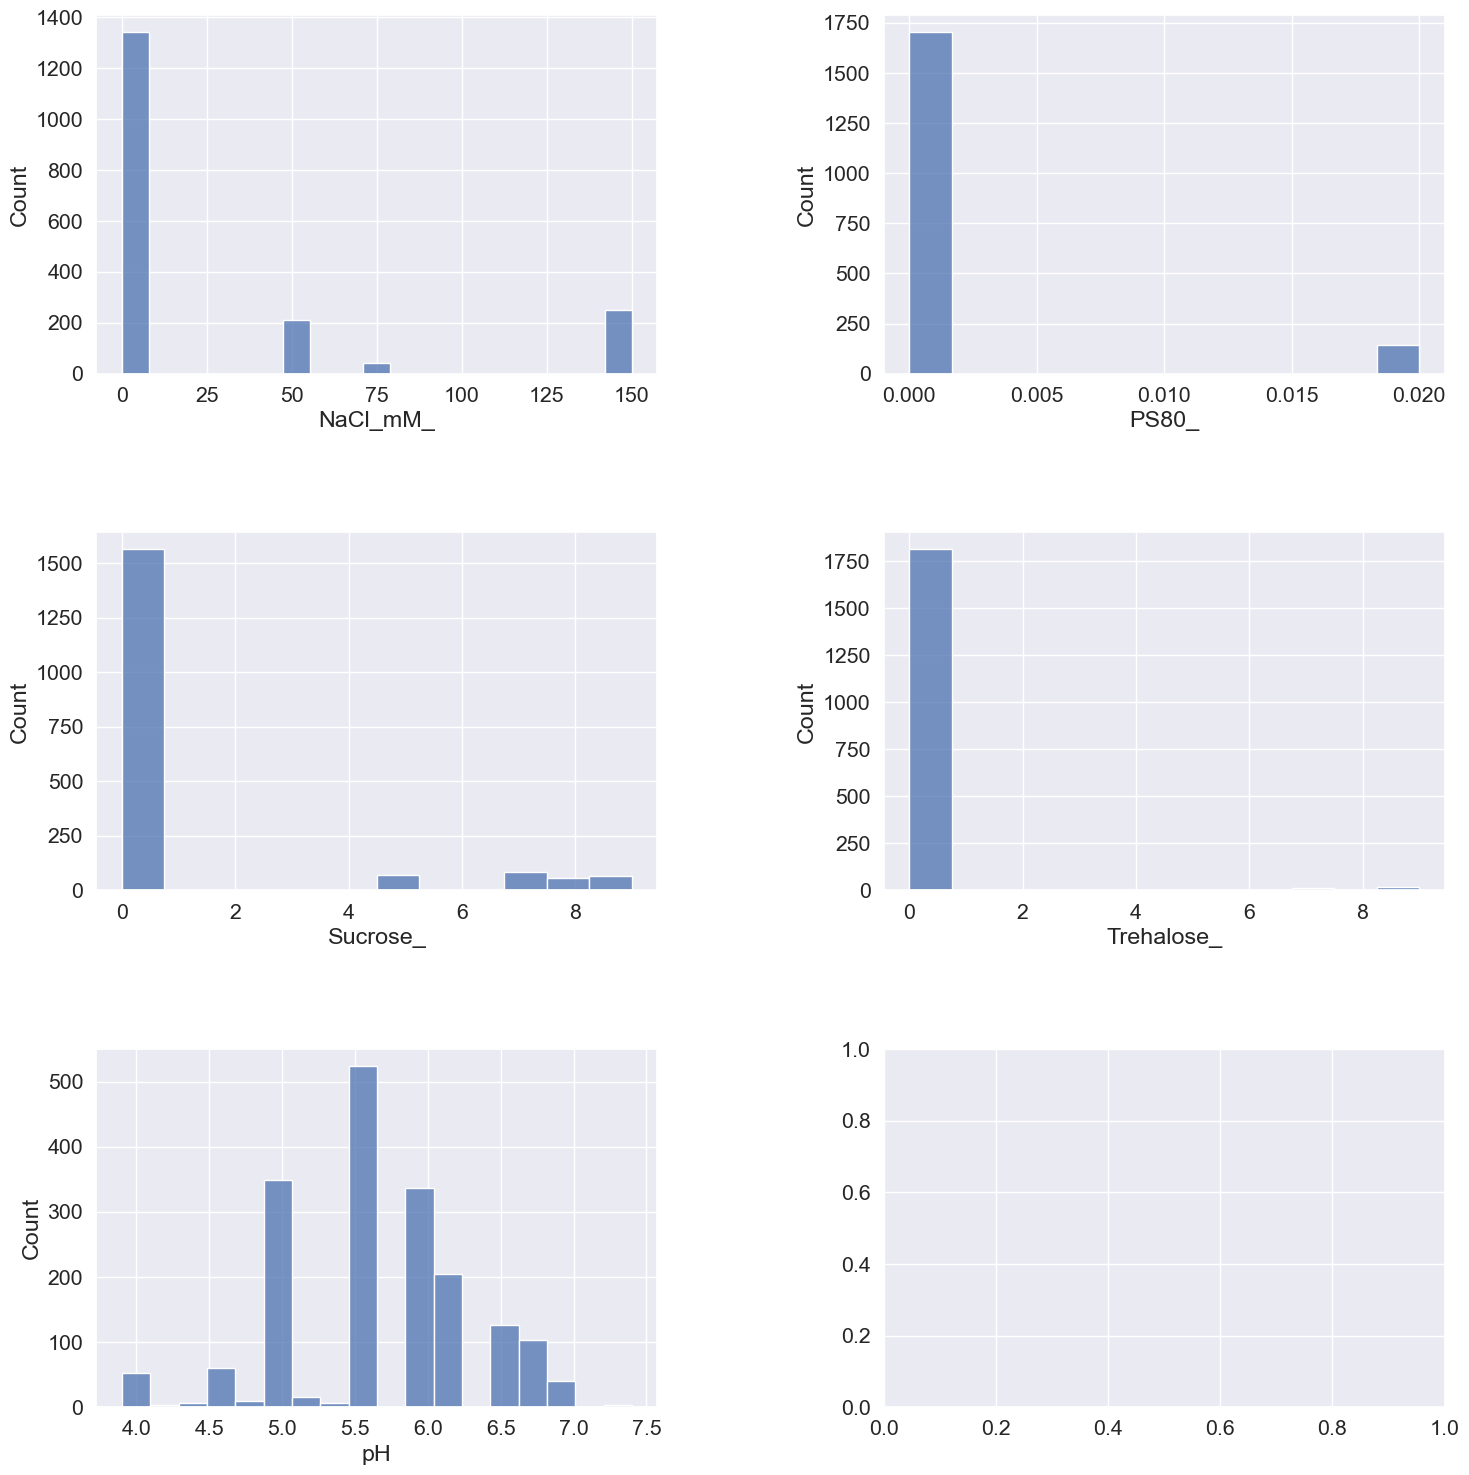

In [19]:
#Distributions of numeric features across all groups
fig, axes = plt.subplots(3,2, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(cols_feature_numeric):
    print(col,df[col].unique())
    sns.histplot(df[col], ax=ax[i]) # histogram call
    #ax[i].set_title(col)
    # remove scientific notation for both axes
    ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
#figName = 'featureDist.jpg'
#plt.savefig(os.path.join(figPath,figName))
plt.show()

In [23]:
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

In [17]:
bins = [-np.inf, 50, 100,np.inf]
names = ['low', 'medium', 'high']

df['NaClRange'] = pd.cut(df['NaCl_mM_'], bins, labels=names)

print(df['NaClRange'].unique())


bins = [-np.inf, 0,1]
names = ['zero', 'positive']

df['PS80_Range'] = pd.cut(df['PS80_'], bins, labels=names)

print(df['PS80_Range'].unique())

bins = [-np.inf, 0,np.inf]
names = ['zero', 'positive']

df['Sucrose_Range'] = pd.cut(df['Sucrose_'], bins, labels=names)

print(df['Sucrose_Range'].unique())

bins = [-np.inf, 0,np.inf]
names = ['zero', 'positive']

df['Trehalose_Range'] = pd.cut(df['Trehalose_'], bins, labels=names)

print(df['Trehalose_Range'].unique())




['low', 'high', 'medium']
Categories (3, object): ['low' < 'medium' < 'high']
['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
['zero', 'positive']
Categories (2, object): ['zero' < 'positive']


Buffer ['Acetate' 'Citrate' 'Histidine' 'Phosphate' 'Glutamate' 'Succinate']
0


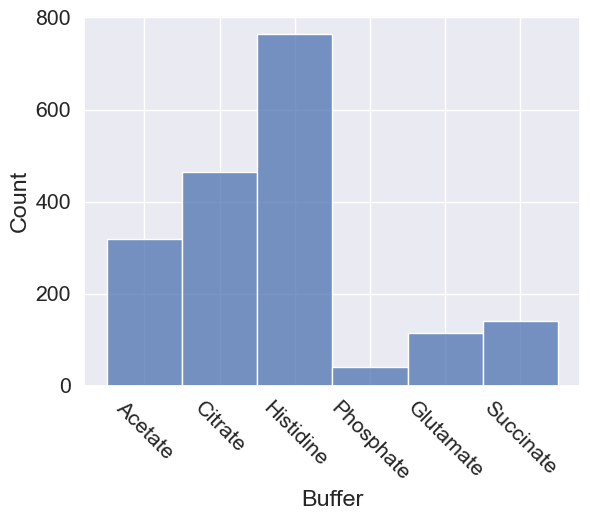

NaClRange ['low', 'high', 'medium']
Categories (3, object): ['low' < 'medium' < 'high']
0


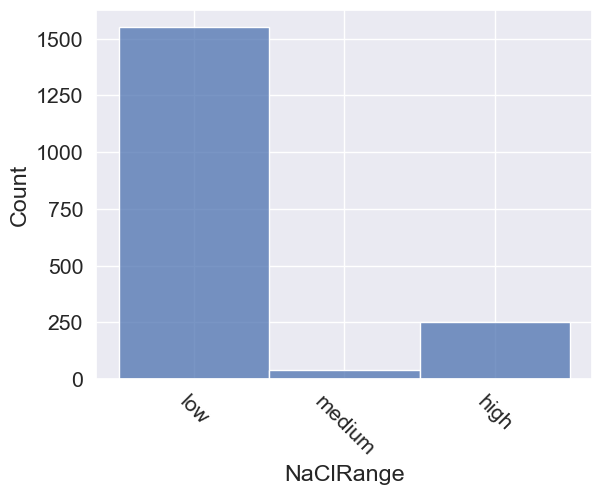

PS80_Range ['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
0


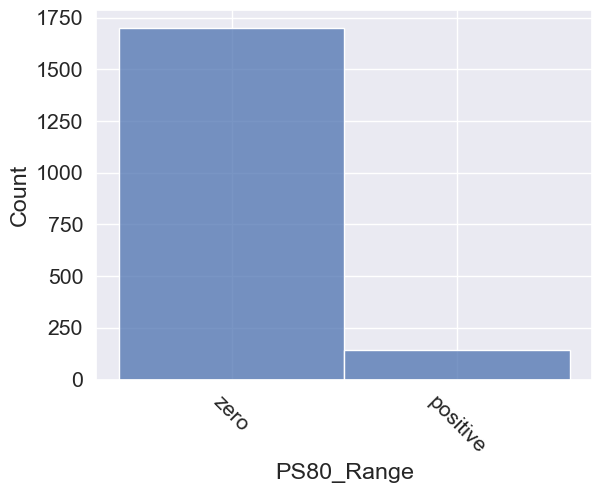

Sucrose_Range ['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
0


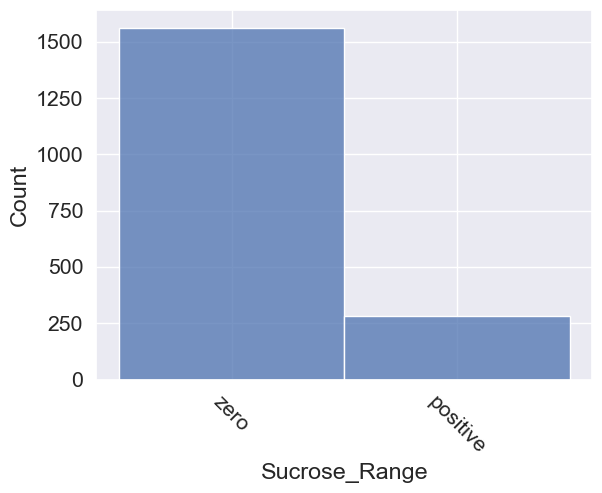

Trehalose_Range ['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
0


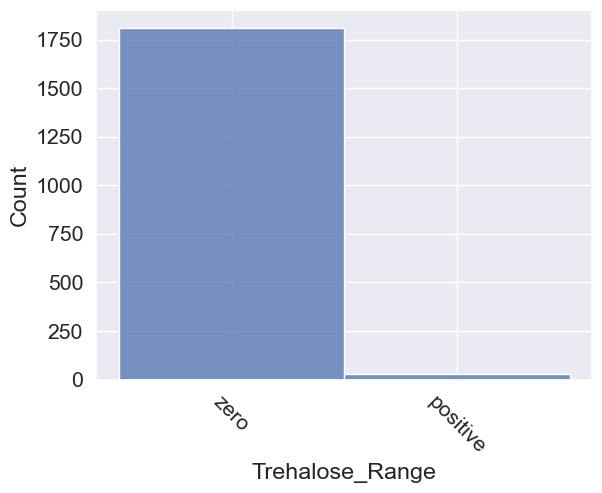

In [21]:
sns.set(font_scale=1.4)

for i, col in enumerate(cols_cate):
    print(col,df[col].unique())
    print(df[col].isna().sum())
    #sns.catplot(data=df, x="Buffer", y="pH", jitter=False)
    sns.histplot(df[col]) 
    fig.tight_layout(w_pad=6, h_pad=4) # change padding
    plt.xticks(rotation=-45)
    plt.show()
    #ax[i].set_title(col)

In [18]:
DROPNA = True

print('Groupby Project')
splits_project = list(df[cols_group + cols_feature01+cols_target].groupby(['Project'],dropna=DROPNA))
ndata_project = [len(df[1]) for df in splits_project]
ls_df_project = [df[1] for df in splits_project if len(df[1])>50]
df_project = pd.concat(ls_df_project)
df_project.reset_index(inplace = True, drop = True)
print(df_project['Project'].unique().shape)
print(df_project['Project'].unique())

print('Groupby Protein')
splits_protein = list(df[cols_group + cols_feature01+cols_target].groupby(['Protein'],dropna=DROPNA))
ndata_protein = [len(df[1]) for df in splits_protein]
ls_df_protein = [df[1] for df in splits_protein if len(df[1])>19]
df_protein = pd.concat(ls_df_protein)
print(df_protein['Protein'].unique().shape)
print(df_protein['Protein'].unique())


print('Groupby Modality')
splits_modality= list(df[cols_group + cols_feature01+cols_target].groupby(['Modality'],dropna=DROPNA))
ndata_modality = [len(df[1]) for df in splits_modality]
ls_df_modality = [df[1] for df in splits_modality if len(df[1])>19]
df_modality = pd.concat(ls_df_modality)
df_modality.reset_index(inplace = True, drop = True)
print(df_modality['Modality'].unique().shape)
print(df_modality['Modality'].unique())

Groupby Project
(7,)
['CEACAM5' 'FAP-TriNKET' 'IL-2Ra' 'Sutro IL-2' 'TRACTr Nectin-4' 'Trop2'
 'aTau']
Groupby Protein
(39,)
['03BHZ' '21BMT' '48BMP' '68BHS' '69BHV' 'AB0411' 'AB0621' 'DAB013887'
 'DAB014071' 'DAB014072' 'DAB014074' 'DAB014234' 'DAB014235' 'DAB014236'
 'DAB014238' 'DCC000159_003' 'DCC000238_004' 'DCC000250_003'
 'DCC000363_035' 'DCC000712_002' 'DCC000770_007' 'DCC000770_035' 'DCC_1A'
 'DCC_2B' 'DNB547' 'DNB553' 'DNB557' 'DNB558' 'Enhertu' 'MK-2032' 'MK3475'
 'ROR1' 'SP009849' 'SP10478' 'SP10482' 'SP10784' 'TDI' 'VLS-101' 'VLS-231']
Groupby Modality
(6,)
['ADC' 'BsAb' 'Fusion Protein' 'Trispecific' 'mAb' 'polymer conjugate']


In [276]:
df[cols_target].isnull().sum().sum() > 0

True

('ADC',)


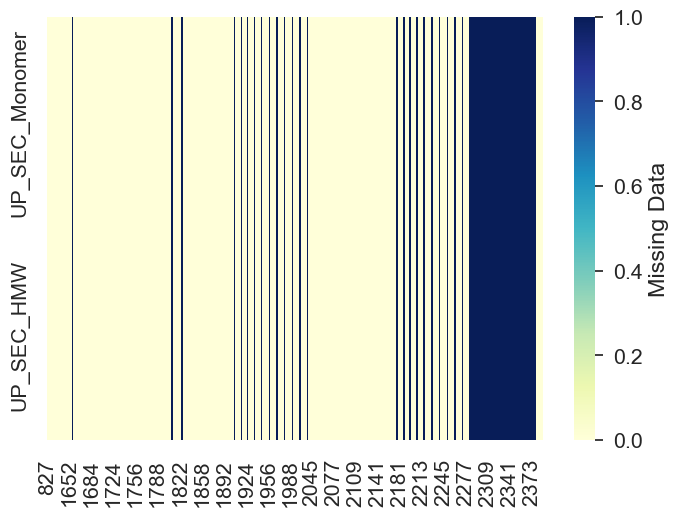

('BsAb',)


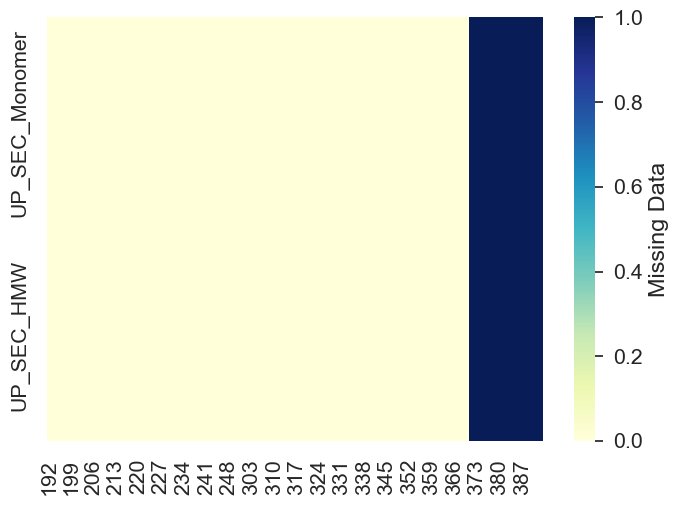

('Fab',)
no missing targets
('Fusion Protein',)
no missing targets
('Trispecific',)
no missing targets
('mAb',)


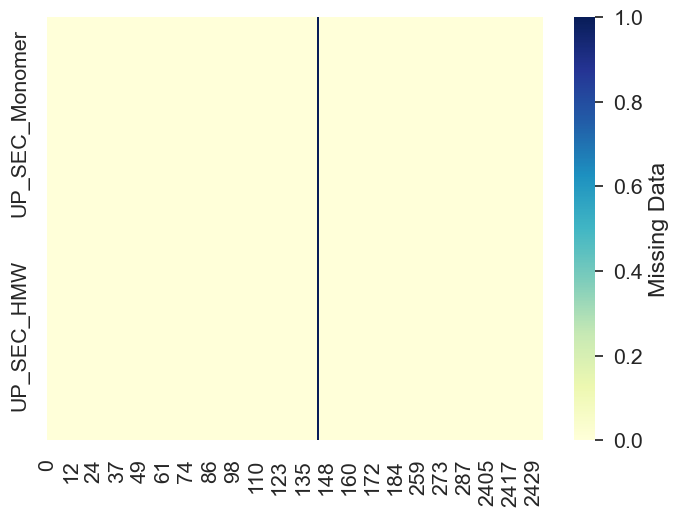

('polymer conjugate',)


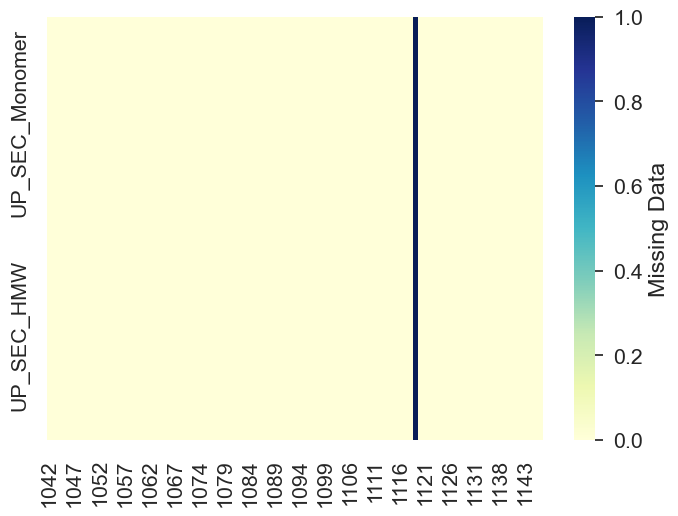

In [277]:
for i,(modality,df) in enumerate(splits_modality):
        print(modality)
        if (df[cols_target].isnull().sum().sum() > 0):
                # missing data visualization across target factors
                sns.set(font_scale=1.4)
                sns.heatmap(df[cols_target].isnull().transpose(), cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
                plt.show()
        else:
                print("no missing targets")

In [156]:
#3d plot
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

def my_get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

ls_project = df_project['Project'].unique()
NUM_COLORS = len(df_project['Project'].unique())
cmap = my_get_cmap(NUM_COLORS)


#cm = plt.get_cmap('gist_rainbow')
ls_color = ['red','green','blue','orange']
colors = dict()
for i,p in enumerate(ls_project):
    colors[p] = ls_color[i]
    #colors[p] = cmap(i)
    #colors[p] = cm(1.*i/NUM_COLORS)

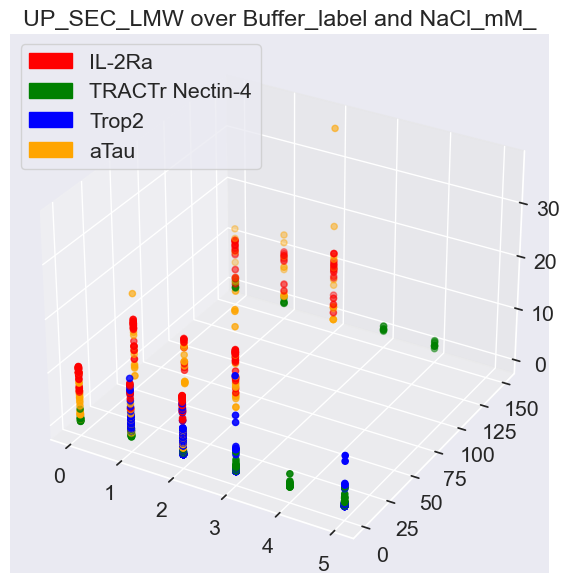

In [159]:
from pandas import factorize
import matplotlib.patches as mpatches 

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

x_name = 'Buffer'
y_name = 'NaCl_mM_'
z_name = cols_target[1]



labels, categories = factorize(df_project[x_name])
x_name = x_name+"_label"
df_project[x_name] = labels


# Creating plot
#ax.scatter(df_project['UP_SEC_Monomer'], df_project['pH'],c=df_project['Project'].map(colors))
ax.scatter3D(df_project[x_name], df_project[y_name], df_project[z_name],c=df_project['Project'].map(colors))
#
plt.title(f'{z_name} over {x_name} and {y_name}')
# Creating legend with color box 
pop_a = mpatches.Patch(label=ls_project[0], color=colors[ls_project[0]]) 
pop_b = mpatches.Patch(label=ls_project[1], color=colors[ls_project[1]])
pop_c = mpatches.Patch(label=ls_project[2], color=colors[ls_project[2]])
pop_d = mpatches.Patch(label=ls_project[3], color=colors[ls_project[3]])
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d]) 

# show plot
plt.show()

## split data by formulation factors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[cols_cate])

ohe_feat_names = enc.get_feature_names_out(cols_cate)
ohe_feat_names

In [199]:
from sklearn.preprocessing import RobustScaler
cols_target_scale = [col+'_scale' for col in cols_target]
df_dropna_target = df.dropna(subset = cols_target)
rb_scaler = RobustScaler()
rb_scaler.fit(df_dropna_target[cols_target])

RobustScaler()

[1, 22, 2, 1, 1, 42, 1, 11, 9, 32, 4, 28, 1, 1, 11, 1, 1, 1, 17, 1, 1, 18, 18, 4, 4, 4, 1, 12, 1, 1, 1, 26, 1, 1, 19, 18, 8, 3, 14, 68, 27, 1, 1, 67, 1, 28, 43, 16, 4, 4, 4, 12, 12, 12, 11, 11, 1, 17, 1, 1, 1, 18, 8, 4, 4, 4, 1, 1, 1, 18, 1, 1, 8, 1, 19, 8, 33, 8, 33, 7, 15, 11, 8, 1, 1, 1, 1, 1, 57, 2, 98, 32, 109, 29, 44, 28, 25, 12, 1, 16, 15, 2, 5, 7, 2, 12, 12, 12, 4, 10, 11, 11, 5, 6, 1, 1, 1, 1, 1, 20, 2, 21, 1, 21, 20, 4, 4, 4, 4, 1, 1, 1, 1, 1, 20, 2, 21, 1, 20, 18, 9, 1, 8, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 8, 1, 8, 25, 18, 25, 7, 2, 1, 12, 12, 12, 8, 6, 4]
92
The list of indices greater than or equal to n_data_th : [5, 9, 39, 43, 46, 76, 78, 88, 90, 91, 92, 94]


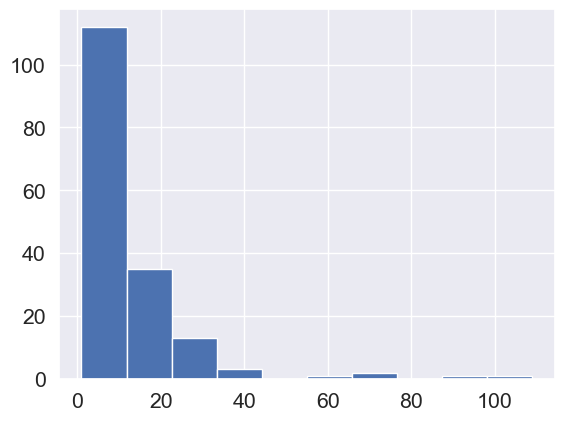

In [198]:
splits_formulation = list(df[cols_group + cols_feature01+cols_target].groupby(cols_feature01,dropna=True))
ndata_formulation = [len(df[1]) for df in splits_formulation]
print(ndata_formulation)
m = max(ndata_formulation)
print(ndata_formulation.index(m))
plt.hist(ndata_formulation)

n_data_th_formulation = 30
res_formulation = [idx for idx, val in enumerate(ndata_formulation) if val >= n_data_th_formulation]
print("The list of indices greater than or equal to n_data_th : " + str(res_formulation))

Best K: 4
Best K: 3
Best K: 3
Best K: 4
Best K: 4
Best K: 6
Best K: 3
Best K: 4
Best K: 4
Best K: 4
Best K: 6
Best K: 4


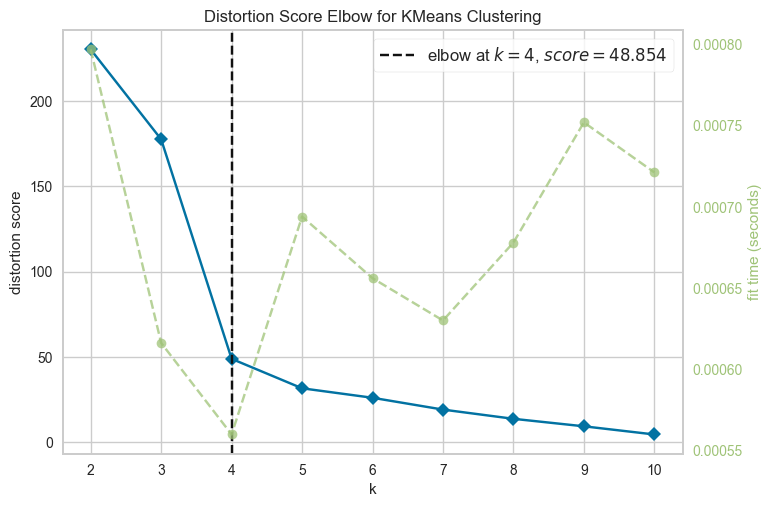

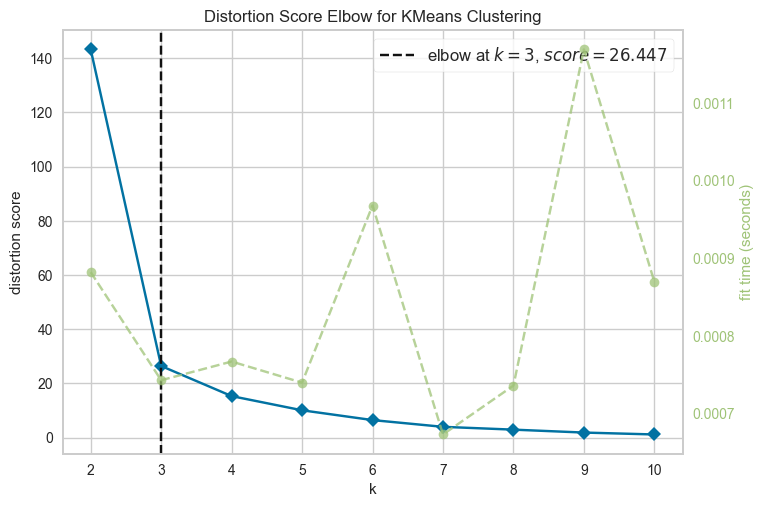

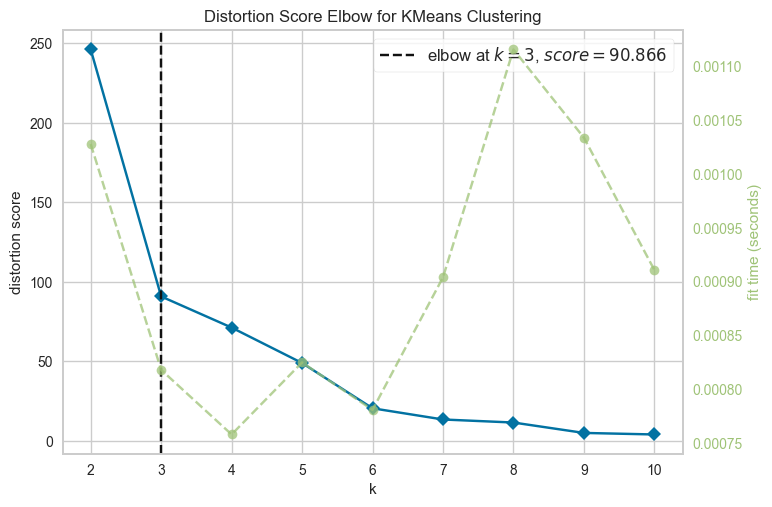

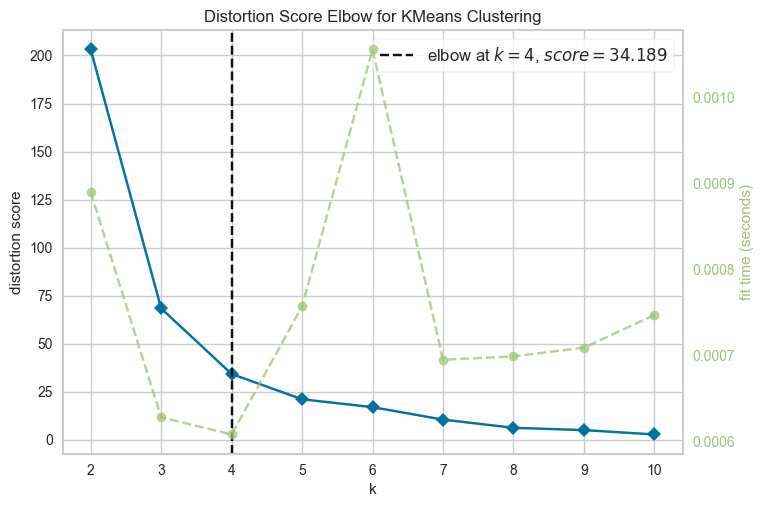

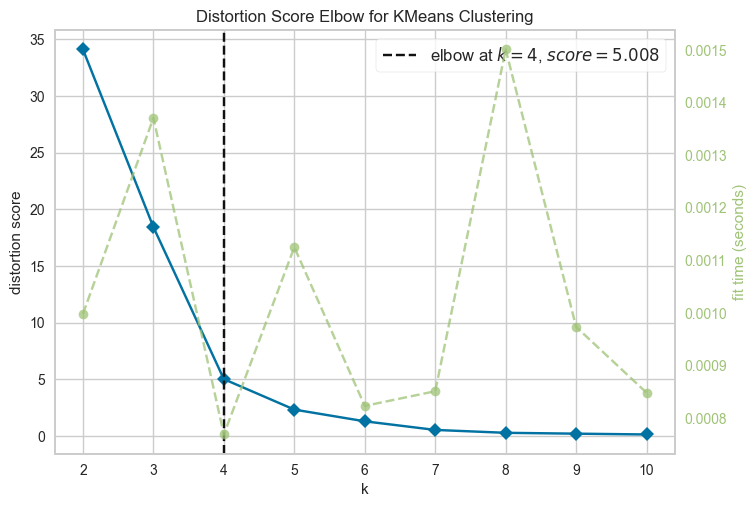

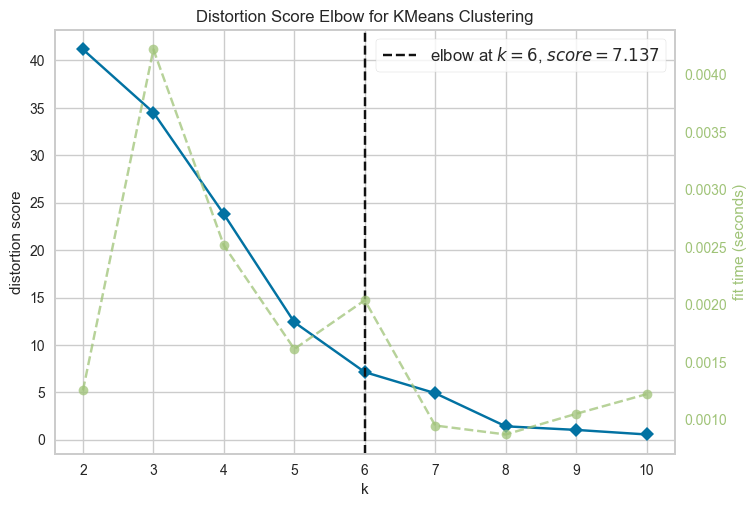

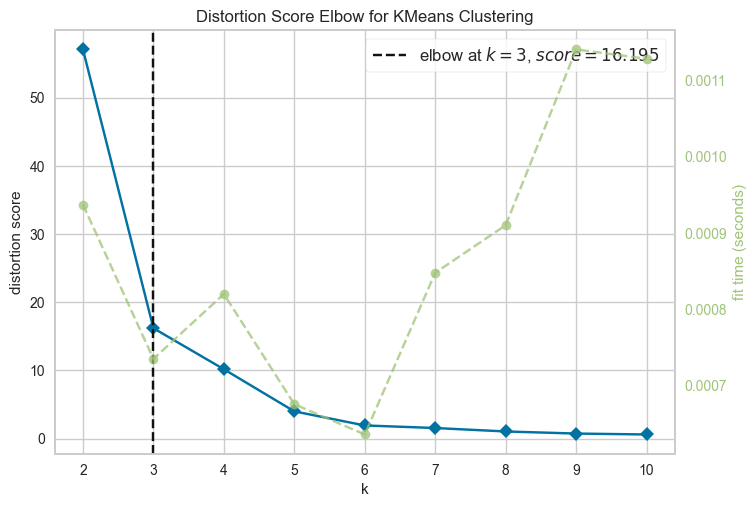

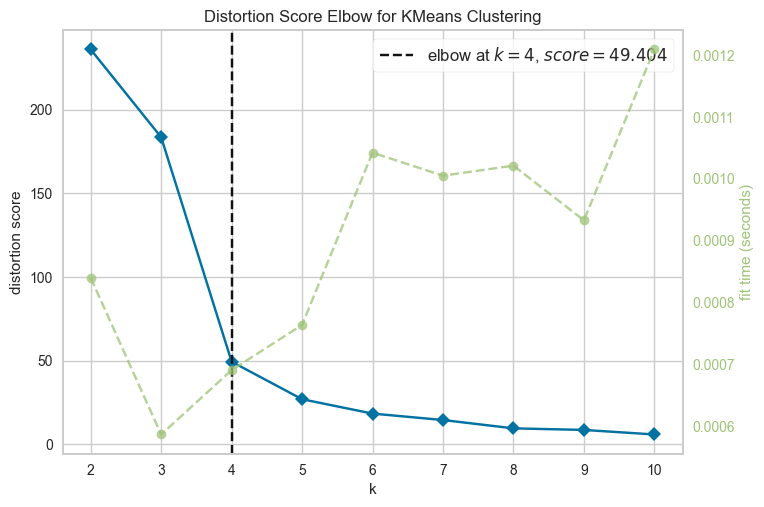

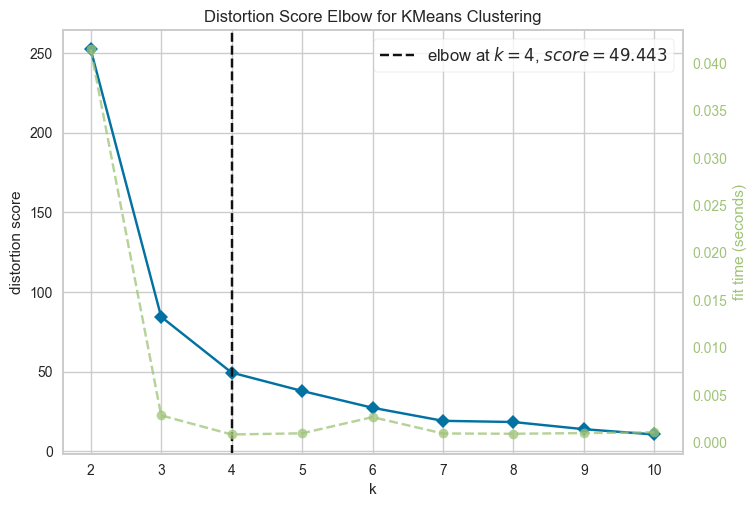

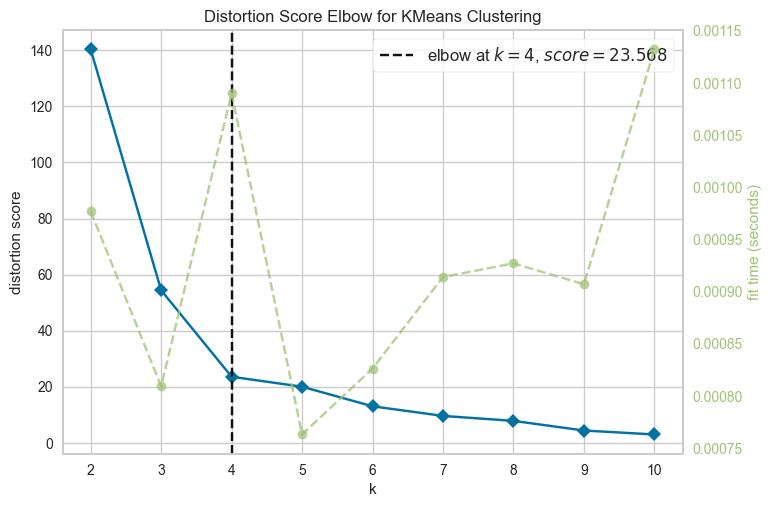

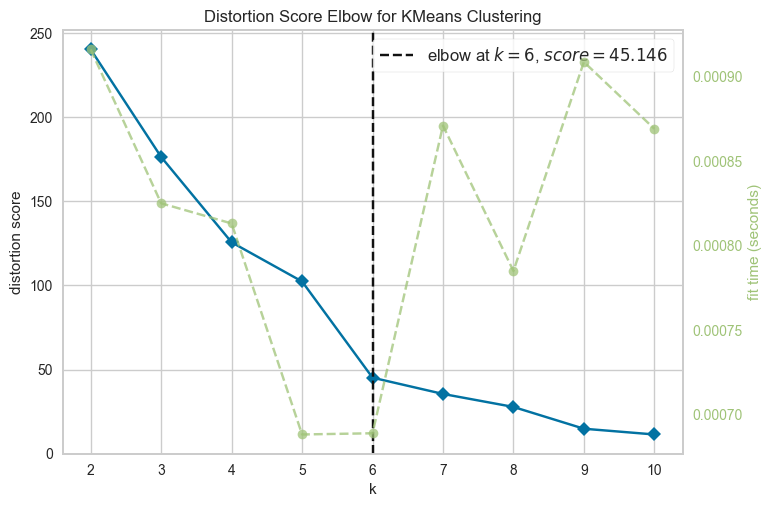

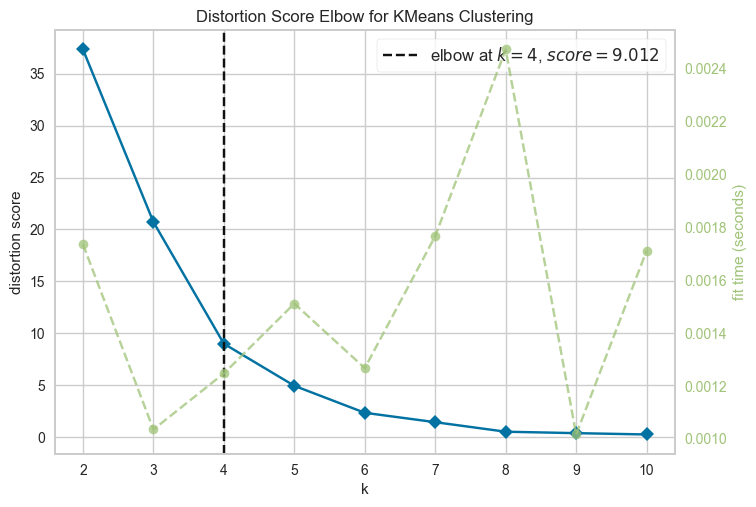

In [236]:
tmp_identifier_cols = ['Protein','Temp_C_','Time_Days_']
from sklearn.cluster import KMeans
K = range(2,11)
from sklearn.metrics import silhouette_score
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

ls_df_dend = []
ls_df_cluster_mode = []

for group_idx in res_formulation:
    #df_for1 = splits_formulation[ndata_formulation.index(m)][1] #most number of data
    df_for1 = splits_formulation[group_idx][1]
    df_for1.dropna(subset = cols_target,inplace = True) #some NA target records causing duplicate data points
    df_for1 = df_for1[df_for1.UP_SEC_HMW < 100] #remove rows where UP_SEC_HMW>=100
    df_for1.reset_index(inplace = True, drop = True)

    gname = [str(e) for e in splits_formulation[group_idx][0]]

    gname_append = [k[0]+'_' +v for k,v in zip(cols_feature01,gname)]

    figPath = 'output/'+'-'.join(gname_append)
    if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

    #scale target columns
    df_for1[cols_target_scale] = rb_scaler.transform(df_for1[cols_target])

    bins = [-np.inf, 50, 100,np.inf]
    names = ['low', 'medium', 'high']

    df_for1['NaClRange'] = pd.cut(df_for1['NaCl_mM_'], bins, labels=names)

    #print(df_for1['NaClRange'].unique())


    bins = [-np.inf, 0,1]
    names = ['zero', 'positive']

    df_for1['PS80_Range'] = pd.cut(df_for1['PS80_'], bins, labels=names)

    #print(df_for1['PS80_Range'].unique())

    bins = [-np.inf, 0,np.inf]
    names = ['zero', 'positive']

    df_for1['Sucrose_Range'] = pd.cut(df_for1['Sucrose_'], bins, labels=names)

    #print(df_for1['Sucrose_Range'].unique())

    bins = [-np.inf, 0,np.inf]
    names = ['zero', 'positive']

    df_for1['Trehalose_Range'] = pd.cut(df_for1['Trehalose_'], bins, labels=names)

    #print(df_for1['Trehalose_Range'].unique())



    splits_df_for1 = list(df_for1[cols_group + cols_cate+ ['pH']+cols_target+cols_target_scale].groupby(tmp_identifier_cols,dropna=True))

    #high_temp_group_ind = {40,41,42}
    #splits_df_for1 = [df for i,df in enumerate(splits_df_for1) if i not in high_temp_group_ind]

    ndata_df_for1 = [len(df[1]) for df in splits_df_for1]
    n_group = len(ndata_df_for1)


    cols_y = cols_target_scale
    simM_y = np.zeros([n_group,n_group])

    for i1,g1 in enumerate(splits_df_for1):
        df1 = g1[1][cols_y]
        df1_adj = df1.dropna()
        if len(df1_adj)==0:
            simM_y[i1,i2] = 0
        else:
            arr1 = df1_adj.to_numpy()
        
            for i2,g2 in enumerate(splits_df_for1):
                df2 = g2[1][cols_y]
                df2_adj = df2.dropna()
                if len(df2_adj)==0:
                    simM_y[i1,i2] = 0
                else:
                    arr2 = df2_adj.to_numpy()
                
                    if i1==i2:
                        simM_y[i1,i2] = 1
                    else:
                        if np.shape(arr2)[0]==1:
                            simM_y[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
                        elif np.shape(arr1)[0]==1:
                            simM_y[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
                        else:
                            simM_y[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)
    
    plt.figure()
    sns.heatmap(simM_y)
    plt.savefig(figPath+'/simM.jpg')
    plt.clf()
    simM_y[np.isnan(simM_y)] = 0
    #convert to symm matrix
    df_simM = pd.DataFrame(simM_y)
    distM = 1-simM_y
    for i in range(distM.shape[0]):
        for j in range(distM.shape[1]):
            if distM[i,j] != distM[j,i]:
                distM[j,i] = distM[i,j]
    df_distM = pd.DataFrame(distM)

    """
    distortions = []
    silhouette_avg = []
    for k in K:
        km = KMeans(n_clusters=k, random_state = 1)
        km.fit(df_distM)
        distortions.append(km.inertia_)
        score = silhouette_score(df_distM, km.labels_)
        silhouette_avg.append(score)

    n_best_c = np.argmax(silhouette_avg)+K[0]
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    """
    km = KMeans(random_state = 1)
    visualizer = KElbowVisualizer(km, k=K)
 
    visualizer.fit(distM)        # Fit the data to the visualizer
    visualizer.show(outpath=figPath+'/km.jpg')        # Finalize and render the figure
    #plt.savefig(figPath+'/km.jpg')
    n_best_c = visualizer.elbow_value_
    #NCLUSTER = 2
    
    print (f"Best K: {n_best_c}")
    km_test = KMeans(n_clusters=n_best_c, random_state = 1)
    km_test.fit(df_distM)
    km_cluster_id = km_test.predict(df_distM)
    #km_cluster_id

    Z_ward = sch.linkage(distM, 'ward')
    hc_ward_id =cut_tree(Z_ward, n_clusters=n_best_c).reshape(-1, )


    #print('group id, (Protein,Temp_C_,Time_Days_), number of samples in group')
    ls_dend_group = [(df[0][0],df[0][1],df[0][2],df[1][cols_target[0]].values.squeeze(),df[1][cols_target[1]].values.squeeze()) for _,df in enumerate(splits_df_for1)]
    df_dend = pd.DataFrame(ls_dend_group, columns =tmp_identifier_cols + cols_target)
    df_dend['km_id'] = km_cluster_id
    df_dend['hc_id'] = hc_ward_id
    df_dend.to_csv(figPath+'/dend_df_cluster.csv')
    ls_df_dend.append(df_dend)

    df_cluster_mode = df_dend.groupby('Protein')['hc_id'].agg([lambda x: pd.Series.mode(x).to_list(),'mean'])
    df_cluster_mode['mean'] = round(df_cluster_mode['mean'],2)
    df_cluster_mode.columns = ['mode','mean']
    df_cluster_mode.to_csv(figPath+'/df_cluster_mode.csv')
    ls_df_cluster_mode.append(df_cluster_mode)

In [250]:
ls_df_only_mode = [df[['Protein','mode']] for df in ls_df_cluster_mode]
#ls_df_only_mode[0]

,Protein,mode
0,03BHZ,[0]
1,21BMT,[0]
2,48BMP,[0]
3,64BLJ,[0]
4,65BKD,[0]
5,68BHS,"[0, 1]"
6,69BHV,[0]
7,98BLE,[0]
8,99BLE,[0]
9,AB0411,[2]


In [247]:
for i,df1 in enumerate(ls_df_cluster_mode):
    for j,df2 in enumerate(ls_df_cluster_mode):
        if i!=j:
            pd.merge(df1,df2,on='Protein', how = 'outer')

In [264]:
#from functools import reduce
#merge_df = reduce(lambda df1,df2: pd.merge(df1,df2,on='Protein', how = 'outer'), ls_df_cluster_mode)

df_merge = ls_df_only_mode[0]
for i,d in enumerate(ls_df_only_mode[1:]):
    df_merge = df_merge.merge(d, on='Protein', how = 'outer')
    df_merge.columns = ['Protein'] + ['mode_'+str(ii) for ii in range(i+2)]

df_merge

,Protein,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_7,mode_8,mode_9,mode_10,mode_11
0,03BHZ,[0],[0],NaN,NaN,NaN,NaN,NaN,[0],NaN,"[0, 1]",NaN,NaN
1,21BMT,[0],[0],NaN,NaN,NaN,NaN,NaN,[0],NaN,[1],NaN,NaN
2,48BMP,[0],[0],NaN,NaN,NaN,NaN,NaN,[0],NaN,[1],NaN,NaN
3,64BLJ,[0],[0],NaN,NaN,NaN,NaN,NaN,[0],NaN,[1],NaN,NaN
4,65BKD,[0],[0],NaN,NaN,NaN,NaN,NaN,[0],NaN,[0],NaN,NaN
5,68BHS,"[0, 1]","[0, 1]",NaN,NaN,NaN,NaN,NaN,[0],NaN,"[0, 1]",NaN,NaN
6,69BHV,[0],"[0, 1]",NaN,NaN,NaN,NaN,NaN,"[0, 1]",NaN,"[0, 1]",NaN,NaN
7,98BLE,[0],[2],NaN,NaN,NaN,NaN,NaN,[0],NaN,[2],NaN,NaN
8,99BLE,[0],[2],NaN,NaN,NaN,NaN,NaN,[0],NaN,[2],NaN,NaN
9,AB0411,[2],[1],NaN,NaN,NaN,NaN,NaN,[1],NaN,[2],NaN,NaN


"\ndend = sch.dendrogram(Z_ward,\n                      truncate_mode='lastp',  # show only the last p merged clusters\n                      p=5,  # show only the last p merged clusters\n    show_leaf_counts=False,  # otherwise numbers in brackets are counts\n    leaf_rotation=90.,\n    leaf_font_size=12.,\n    show_contracted=True,  # to get a distribution impression in truncated branches\n)\n"

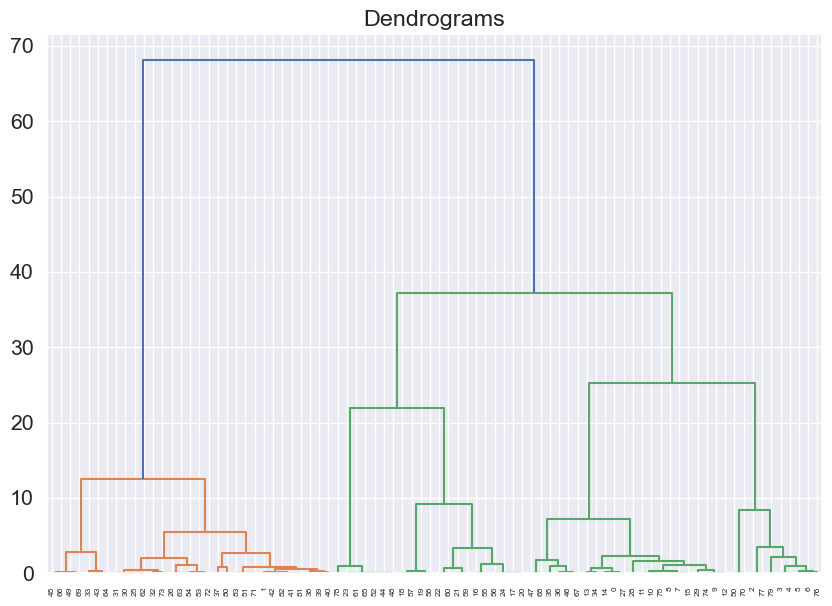

In [120]:
## hierarchical clustering

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
Z_ward = sch.linkage(distM, 'ward')
dend = sch.dendrogram(Z_ward)
"""
dend = sch.dendrogram(Z_ward,
                      truncate_mode='lastp',  # show only the last p merged clusters
                      p=5,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
"""

In [126]:
Z_ward = sch.linkage(distM, 'ward')
hc_ward_id =cut_tree(Z_ward, n_clusters=NCLUSTER).reshape(-1, )
print(hc_ward_id)

Z_complete= linkage(distM, 'complete')
# Extract the membership to a cluster, either specify the n_clusters
# or the cut height
# (similar to sklearn labels)
#print(cut_tree(Z, n_clusters=2))
hc_complete_id =cut_tree(Z_complete, n_clusters=NCLUSTER).reshape(-1, )
#h_cluster_id =cut_tree(Z, height=6).reshape(-1, )
#print(cut_tree(Z, height=4))
print(hc_complete_id)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1
 0 0 0 0 0 0 1 1 1 1]
[0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1]


30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


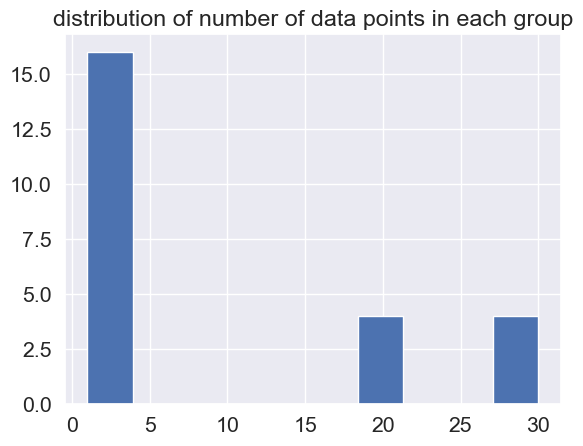

In [23]:
# split dataframe using gropuby
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits = list(df[cols_group + cols_cate+cols_target + ['pH']].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

### clustering using formulation factors

In [24]:


n_group = len(splits)
simM = np.zeros([n_group,n_group])

for i1,g1 in enumerate(splits):
    df1 = g1[1]
    
    #split features into numeric and categorical
    #numeric_feat = df1[cols_feature01].select_dtypes(include=[np.number])
    #cate_feat = df1[cols_feature01].select_dtypes(exclude=[np.number])
    numeric_feat = df1['pH']
    cate_feat = df1[cols_cate]
    numeric_feat.reset_index(inplace = True, drop = True)
    cate_feat.reset_index(inplace = True, drop = True)

    #convert cate features to one-hot encoding
    #one_hot_cate_feat = pd.get_dummies(cate_feat, columns = ['Buffer'])
    one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

    df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
    arr1 = df1_feat.to_numpy()

    for i2,g2 in enumerate(splits):
        df2 = g2[1]
    
        #split features into numeric and categorical
        numeric_feat = df2['pH']
        cate_feat = df2[cols_cate]
        numeric_feat.reset_index(inplace = True, drop = True)
        cate_feat.reset_index(inplace = True, drop = True)

        #convert cate features to one-hot encoding
        #one_hot_cate_feat = pd.get_dummies(cate_feat, columns = ['Buffer'])
        one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

        df2_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
        arr2 = df2_feat.to_numpy()
        
        if i1==i2:
            simM[i1,i2] = 1
        else:
            if np.shape(arr2)[0]==1:
                simM[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
            elif np.shape(arr1)[0]==1:
                simM[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
            else:
                simM[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)

<Axes: >

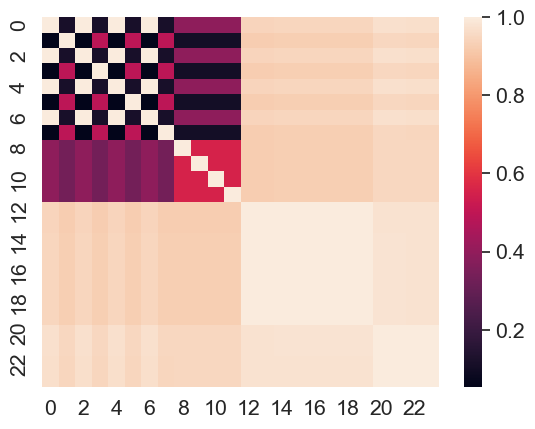

In [25]:
sns.heatmap(simM)

### Kmeans clustering

In [105]:
#convert to symm matrix
df_simM = pd.DataFrame(simM)
distM = 1-simM
for i in range(distM.shape[0]):
    for j in range(distM.shape[1]):
        if distM[i,j] != distM[j,i]:
            distM[j,i] = distM[i,j]
df_distM = pd.DataFrame(distM)
#df_distM

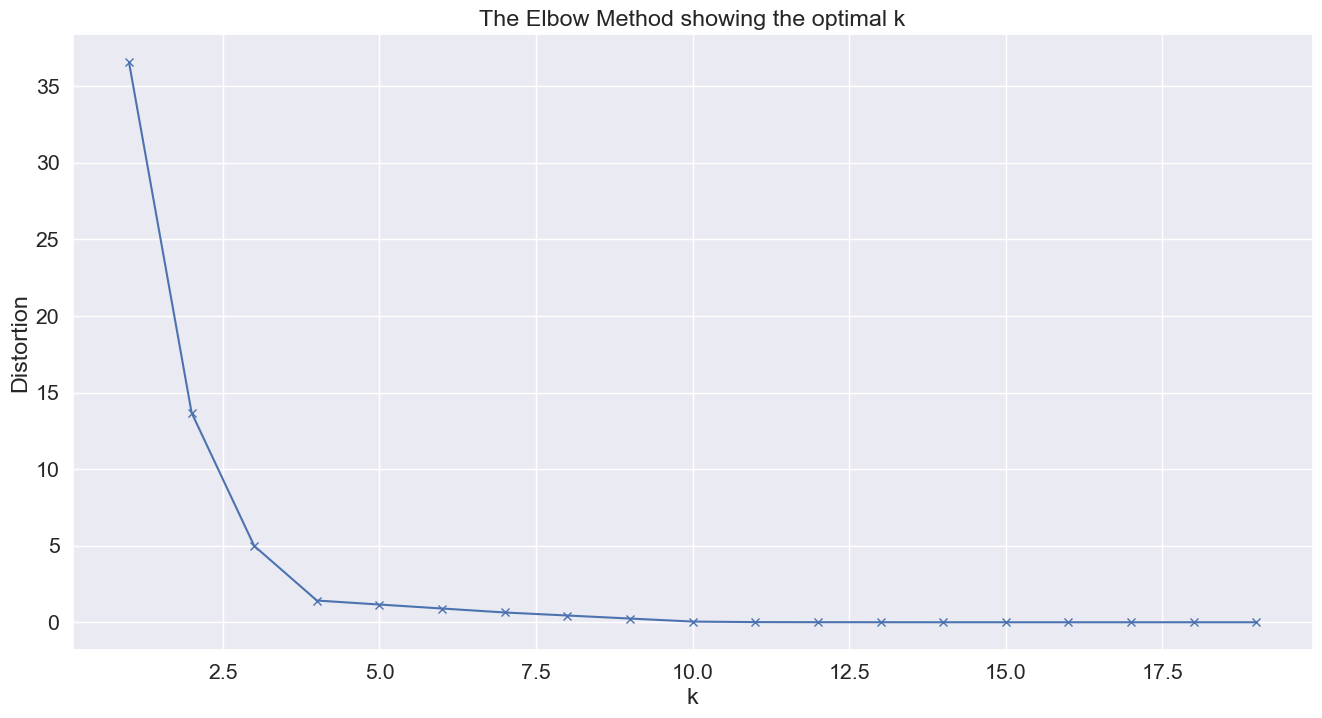

In [106]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 1)
    kmeanModel.fit(df_distM)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [107]:
#rom the above elbow method, we choose 4 as the number of clusters
km = KMeans(n_clusters=4, random_state = 1)
km.fit(df_distM)
km_cluster_id = km.predict(df_distM)
km_cluster_id

array([3, 2, 3, 2, 3, 2, 3, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

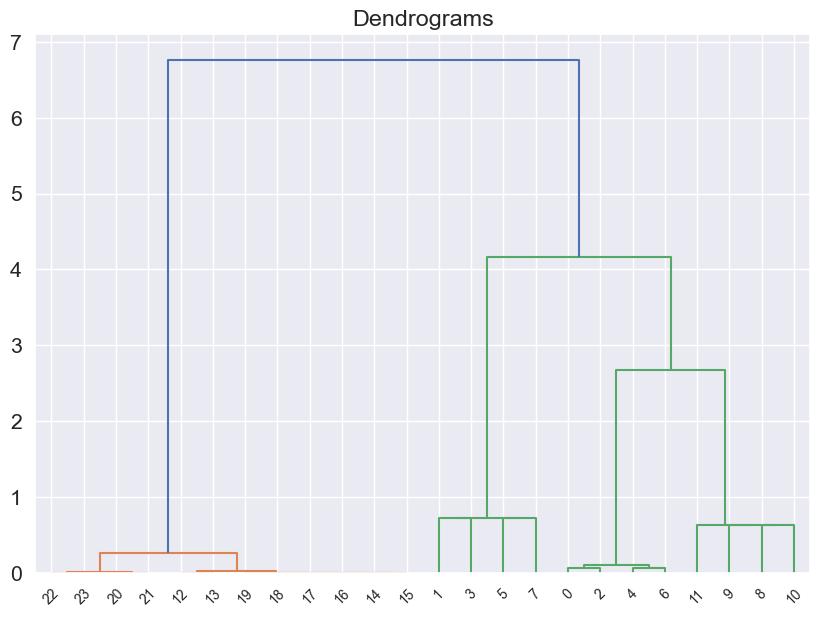

In [108]:
## hierarchical clustering
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = sch.dendrogram(sch.linkage(distM, method='ward'))
#[(i,df[0],len(df[1])) for i,df in enumerate(splits)]

In [26]:
[(i,df[0],len(df[1])) for i,df in enumerate(splits)]

[(0, ('FAP-TriNKET', 'DAB013887', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (1, ('FAP-TriNKET', 'DAB013887', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (2, ('FAP-TriNKET', 'DAB014071', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (3, ('FAP-TriNKET', 'DAB014071', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (4, ('FAP-TriNKET', 'DAB014072', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (5, ('FAP-TriNKET', 'DAB014072', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (6, ('FAP-TriNKET', 'DAB014074', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (7, ('FAP-TriNKET', 'DAB014074', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (8, ('IL-2Ra', 'DNB547', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0), 30),
 (9, ('IL-2Ra', 'DNB553', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0), 30),
 (10,
  ('IL-2Ra', 'DNB557', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0),
  30),
 (11,
  ('IL-2Ra', 'DNB558', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0),
  30),
 (12, ('Surfactant', 'DAB015692_013', 'ADC', 'Thermal 

### clustering using formulation and target variables

In [27]:
#cols_xy = cols_feature01 + cols_target
cols_xy = cols_cate+['pH']+cols_target
simM_xy = np.zeros([n_group,n_group])
#splits = list(df.groupby(cols_group,dropna=is_drop_na))

for i1,g1 in enumerate(splits):
    df1 = g1[1][cols_xy]
    df1_adj = df1.dropna()
    if len(df1_adj)==0:
        simM_xy[i1,i2] = 0
    else:
        #split features into numeric and categorical
        numeric_feat = df1_adj[['pH']+cols_target]
        cate_feat = df1_adj[cols_cate]
        numeric_feat.reset_index(inplace = True, drop = True)
        cate_feat.reset_index(inplace = True, drop = True)

        #convert cate features to one-hot encoding
        one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

        df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
        arr1 = df1_feat.to_numpy()
    
        for i2,g2 in enumerate(splits):
            df2 = g2[1][cols_xy]
            df2_adj = df2.dropna()
            if len(df2_adj)==0:
                simM_xy[i1,i2] = 0
            else:
                #split features into numeric and categorical
                numeric_feat = df2_adj[['pH']+cols_target]
                cate_feat = df2_adj[cols_cate]
                numeric_feat.reset_index(inplace = True, drop = True)
                cate_feat.reset_index(inplace = True, drop = True)

                #convert cate features to one-hot encoding
                one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

                df2_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
                arr2 = df2_feat.to_numpy()
        

                if i1==i2:
                    simM_xy[i1,i2] = 1
                else:
                    if np.shape(arr2)[0]==1:
                        simM_xy[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
                    elif np.shape(arr1)[0]==1:
                        simM_xy[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
                    else:
                        simM_xy[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)

<Axes: >

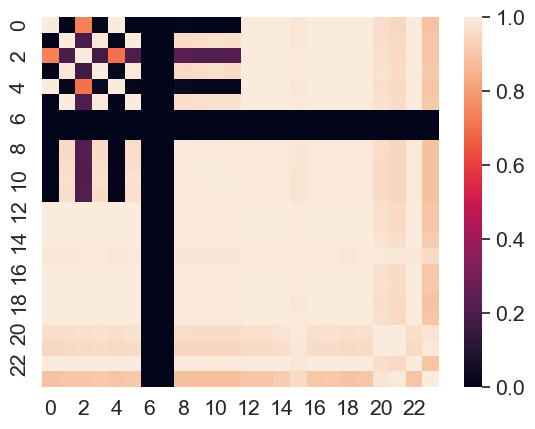

In [28]:
sns.heatmap(simM_xy)

In [29]:
#cols_y = ['Buffer'] + cols_target
cols_y = cols_target
simM_y = np.zeros([n_group,n_group])
splits = list(df.groupby(cols_group,dropna=is_drop_na))

for i1,g1 in enumerate(splits):
    df1 = g1[1][cols_y]
    df1_adj = df1.dropna()
    if len(df1_adj)==0:
        simM_y[i1,i2] = 0
    else:
        """
        #split features into numeric and categorical
        numeric_feat = df1_adj[cols_y].select_dtypes(include=[np.number])
        cate_feat = df1_adj[cols_y].select_dtypes(exclude=[np.number])
        numeric_feat.reset_index(inplace = True, drop = True)
        cate_feat.reset_index(inplace = True, drop = True)

        #convert cate features to one-hot encoding
        one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

        df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
        arr1 = df1_feat.to_numpy()
        """
        arr1 = df1_adj.to_numpy()
        
        for i2,g2 in enumerate(splits):
            df2 = g2[1][cols_y]
            df2_adj = df2.dropna()
            if len(df2_adj)==0:
                simM_y[i1,i2] = 0
            else:
                """
                #split features into numeric and categorical
                numeric_feat = df2_adj[cols_y].select_dtypes(include=[np.number])
                cate_feat = df2_adj[cols_y].select_dtypes(exclude=[np.number])
                numeric_feat.reset_index(inplace = True, drop = True)
                cate_feat.reset_index(inplace = True, drop = True)

                #convert cate features to one-hot encoding
                one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

                df2_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
                arr2 = df2_feat.to_numpy()
                """
                arr2 = df2_adj.to_numpy()
                
                if i1==i2:
                    simM_y[i1,i2] = 1
                else:
                    if np.shape(arr2)[0]==1:
                        simM_y[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
                    elif np.shape(arr1)[0]==1:
                        simM_y[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
                    else:
                        simM_y[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)

<Axes: >

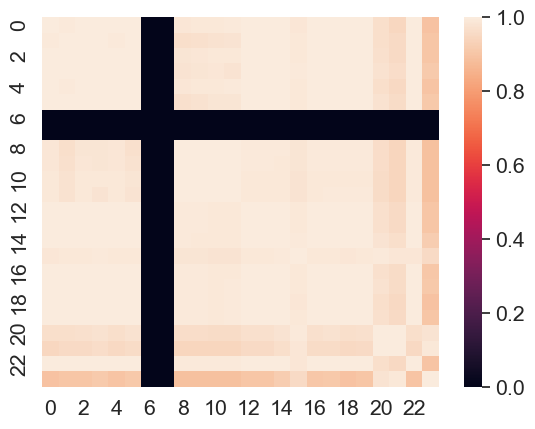

In [30]:
sns.heatmap(simM_y)

# Modeling

In [182]:

#tmp1 = splits[8][1][cols_target + cols_cate + ['pH']]
#tmp2 = splits[9][1][cols_target + cols_cate + ['pH']]
#tmp3 = splits[10][1][cols_target + cols_cate + ['pH']]
#df1 = pd.concat([tmp1,tmp2,tmp3])

In [176]:
group_idx =8
df1 = splits[group_idx][1][cols_target + cols_cate + ['pH']]
df1_adj = df1.dropna()
i = df1_adj[((df1_adj.UP_SEC_HMW >2) )].index
df1_adj.drop(i,inplace=True)

numeric_feat = df1_adj[cols_cate + ['pH']].select_dtypes(include=[np.number])
cate_feat = df1_adj[cols_cate + ['pH']].select_dtypes(exclude=[np.number])
numeric_feat.reset_index(inplace = True, drop = True)
cate_feat.reset_index(inplace = True, drop = True)

#convert cate features to one-hot encoding
one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)

In [177]:
# Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df1_feat, df1_adj[cols_target], test_size=0.2, random_state=0)
# scale features
scaler = MinMaxScaler()
X_train=scaler.fit_transform(df_X_train)
X_test=scaler.transform(df_X_test)

feature_names = df1_feat.columns

In [180]:
#https://stackoverflow.com/questions/62376164/how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize

class MyGPR(GaussianProcessRegressor):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        #self._max_iter = max_iter

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        def new_optimizer(obj_func, initial_theta, bounds):
            return scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                options={'maxiter': 15000},
            )
        self.optimizer = new_optimizer
        return super()._constrained_optimization(obj_func, initial_theta, bounds)

In [181]:
from sklearn.utils.optimize import _check_optimize_result

class MyGPR2(GaussianProcessRegressor):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        #self._max_iter = max_iter
        #self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':15000})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

In [182]:
from sklearn import metrics
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))

UP_SEC_Monomer
316**2 * RBF(length_scale=0.01)
(array([1]),)
Mean Absolute Error (MAE): 15.43
Mean Squared Error (MSE): 1387.23
Root Mean Squared Error (RMSE): 37.25
Mean Absolute Percentage Error (MAPE): 0.17
Explained Variance Score: -6795.18
Max Error: 91.23
Median Absolute Error: 0.36
R^2: -8167.60
UP_SEC_LMW
316**2 * RBF(length_scale=0.01)
(array([1]),)
Mean Absolute Error (MAE): 1.66
Mean Squared Error (MSE): 12.32
Root Mean Squared Error (RMSE): 3.51
Mean Absolute Percentage Error (MAPE): 0.19
Explained Variance Score: -53.91
Max Error: 8.57
Median Absolute Error: 0.35
R^2: -63.95
UP_SEC_HMW
316**2 * RBF(length_scale=0.01)
Mean Absolute Error (MAE): 0.05
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.09
Mean Absolute Percentage Error (MAPE): 60047995031606.72
Explained Variance Score: -0.32
Max Error: 0.20
Median Absolute Error: 0.00
R^2: -0.39


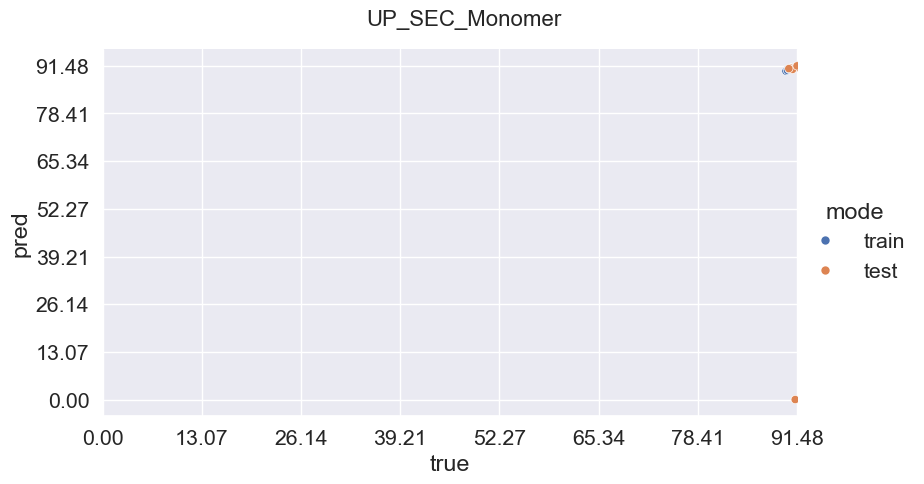

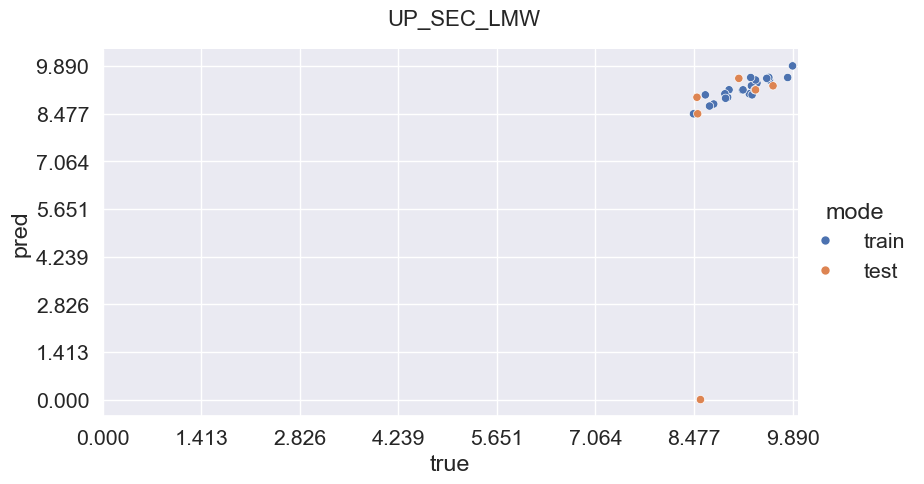

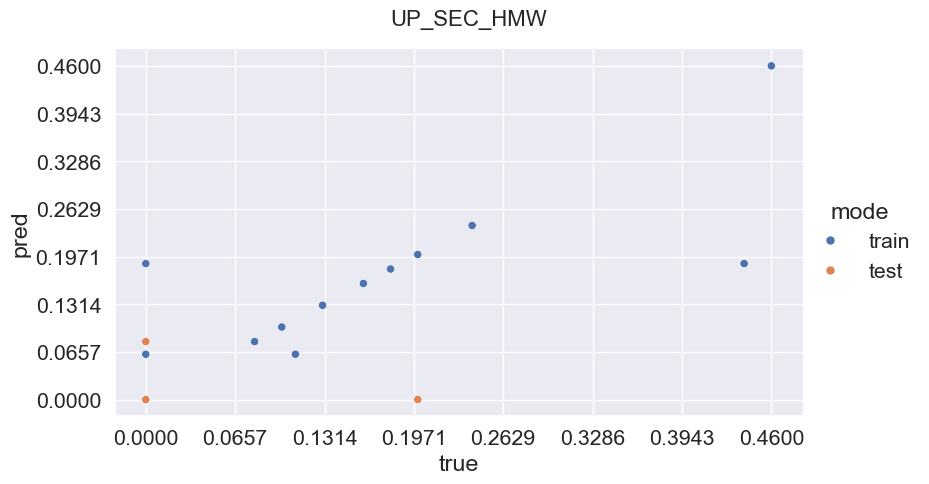

In [184]:
for tmp_col_y in cols_target:
    print(tmp_col_y)
    #gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    #gaussian_process.fit(X_train,df_y_train[tmp_col_y])
    my_gpr = MyGPR2(kernel=kernel, n_restarts_optimizer=9)
    my_gpr.fit(X_train,df_y_train[tmp_col_y])
    print(my_gpr.kernel_)
    y_true = df_y_test[tmp_col_y].values
    mean_pred, std_pred = my_gpr.predict(X_test, return_std=True)
    mean_train, std_train = my_gpr.predict(X_train, return_std=True)
    y_pred = mean_pred

    if tmp_col_y!='UP_SEC_HMW':
        print(np.where(abs(y_pred-y_true)>7))
    """
    plt.figure(figsize=(12,6))
    sns.scatterplot(x=y_true.reshape(-1), y=y_pred.reshape(-1), color='blue', label = 'GP prediction')
    sns.scatterplot(x=y_true.reshape(-1), y=y_true.reshape(-1), color='red', label = 'actual data')
    sns.scatterplot(x=y_true.reshape(-1), y=(y_pred+1*std_pred).reshape(-1), color='yellow', label = 'pred+1*std')
    sns.scatterplot(x=y_true.reshape(-1), y=(y_pred-1*std_pred).reshape(-1), color='black', label = 'pred-1*std')
    """

    test_comp = np.concatenate((y_true.reshape(1,-1),y_pred.reshape(1,-1)))
    df_test_comp = pd.DataFrame(test_comp.transpose(),columns = ['true','pred'])
    df_test_comp['mode'] = 'test'

    y_train = df_y_train[tmp_col_y].values
    train_comp = np.concatenate((y_train.reshape(1,-1),mean_train.reshape(1,-1)))
    df_train_comp = pd.DataFrame(train_comp.transpose(),columns = ['true','pred'])
    df_train_comp['mode'] = 'train'

    df_comp = pd.concat([df_train_comp,df_test_comp])

    _modes = ['train','test']
    g = sns.relplot(data=df_comp, x='true', y='pred', hue='mode', hue_order=_modes, aspect=1.61)
    axis_max = max(max(df_comp['true']),max(df_comp['pred']))
    axis_min = min(min(df_comp['true']),min(df_comp['pred']))
    g.set(xticks=np.linspace(start=axis_min, stop=axis_max, num=8),
       yticks=np.linspace(start=axis_min, stop=axis_max, num=8))
    g.fig.suptitle(tmp_col_y, fontsize=16)
    g.fig.subplots_adjust(top=0.9);
    #plt.show()

    print('Mean Absolute Error (MAE):', "{:.2f}".format(metrics.mean_absolute_error(y_true, y_pred)))
    print('Mean Squared Error (MSE):', "{:.2f}".format(metrics.mean_squared_error(y_true, y_pred)))
    print('Root Mean Squared Error (RMSE):', "{:.2f}".format(metrics.root_mean_squared_error(y_true, y_pred)))
    print('Mean Absolute Percentage Error (MAPE):', "{:.2f}".format(metrics.mean_absolute_percentage_error(y_true, y_pred)))
    print('Explained Variance Score:', "{:.2f}".format(metrics.explained_variance_score(y_true, y_pred)))
    print('Max Error:', "{:.2f}".format(metrics.max_error(y_true, y_pred)))
    #print('Mean Squared Log Error:', "{:.2f}".format(metrics.mean_squared_log_error(y_true, y_pred)))
    print('Median Absolute Error:', "{:.2f}".format(metrics.median_absolute_error(y_true, y_pred)))
    print('R^2:', "{:.2f}".format(metrics.r2_score(y_true, y_pred)))